Feature selection using SelectFromModel with RidgeCV and LassoCV

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier


from sklearn.feature_selection import SelectKBest, chi2

from tqdm import tqdm
import warnings
from pprint import pprint

In [2]:
data = pd.read_csv("../data/augmented_data.csv")

In [3]:
data.nunique()

period                     5
minute                   139
possession               290
duration               78059
play_pattern               9
position                  25
location_x               635
location_x_distance      635
location_y               702
location_y_distance      472
technique                  7
body_part                  4
type                       5
is_penalty                 2
first_time                 2
open_goal                  2
one_on_one                 2
aerial_won                 2
follows_dribble            2
under_pressure             2
pass_duration          11912
pass_angle             10519
pass_type                  8
pass_height                4
pass_length             9930
num_passes                13
defenders_3m_radius       10
defenders_triangle        13
goalkeeper_x             258
goalkeeper_y             355
distance_to_goalie     45564
statsbomb_xg           82551
end_location_x           376
end_location_y           705
is_goal       

In [4]:
data.columns

Index(['period', 'minute', 'possession', 'duration', 'play_pattern',
       'position', 'location_x', 'location_x_distance', 'location_y',
       'location_y_distance', 'technique', 'body_part', 'type', 'is_penalty',
       'first_time', 'open_goal', 'one_on_one', 'aerial_won',
       'follows_dribble', 'under_pressure', 'pass_duration', 'pass_angle',
       'pass_type', 'pass_height', 'pass_length', 'num_passes',
       'defenders_3m_radius', 'defenders_triangle', 'goalkeeper_x',
       'goalkeeper_y', 'distance_to_goalie', 'statsbomb_xg', 'end_location_x',
       'end_location_y', 'is_goal', 'shot_angle'],
      dtype='object')

In [5]:
# Use mutual_info classification to check which features yield the most information about the target variable
data_copy = data.copy()
X = data_copy.drop(["statsbomb_xg", "is_goal", "end_location_x", "end_location_y", "location_x", "location_y", "play_pattern", "technique", "position", "body_part", "type", "pass_type", "pass_height"], axis=1)
mutual_info = mutual_info_classif(X, data["is_goal"])
mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info.sort_values(ascending=False)

distance_to_goalie     0.058925
defenders_triangle     0.038393
location_x_distance    0.033417
goalkeeper_x           0.027324
defenders_3m_radius    0.024355
location_y_distance    0.022388
duration               0.021433
goalkeeper_y           0.020557
is_penalty             0.015958
shot_angle             0.014350
open_goal              0.011439
pass_duration          0.009595
pass_length            0.009442
period                 0.008588
num_passes             0.007540
first_time             0.005307
minute                 0.005206
one_on_one             0.004048
pass_angle             0.004007
under_pressure         0.002261
possession             0.001315
aerial_won             0.000222
follows_dribble        0.000000
dtype: float64

In [6]:
# drop redundant features
data.drop(["location_x", "location_y"], axis=1, inplace=True)
# drop features that leak target information
data.drop(["shot_angle"], axis=1, inplace=True)
# drop low information features
data.drop(["aerial_won", "duration", "follows_dribble", "possession", "minute", "period", "num_passes", "pass_duration", "pass_height", "pass_type", "type"], axis=1, inplace=True)
# "position", "body_part", "type", "pass_height", "pass_type"

In [7]:
# one-hot encode the categorical data
encoded_data = data
for column_name in ["play_pattern", "technique", "body_part"]:
    one_hot_encoded = pd.get_dummies(encoded_data[column_name], prefix=column_name)
    encoded_data = encoded_data.drop(column_name, axis=1)
    encoded_data = pd.concat([encoded_data, one_hot_encoded], axis=1)
data = encoded_data

In [8]:
data

,position,location_x_distance,location_y_distance,is_penalty,first_time,open_goal,one_on_one,under_pressure,pass_angle,pass_length,...,technique_Diving Header,technique_Half Volley,technique_Lob,technique_Normal,technique_Overhead Kick,technique_Volley,body_part_Head,body_part_Left Foot,body_part_Other,body_part_Right Foot
0,Left Wing Back,11.9,8.8,False,True,False,False,False,-0.128411,31.695137,...,0,1,0,0,0,0,0,1,0,0
1,Center Forward,9.1,2.6,False,True,False,False,False,-0.128411,31.695137,...,0,0,0,0,0,1,0,0,0,1
2,Left Attacking Midfield,2.1,10.9,False,True,False,False,True,-0.128411,31.695137,...,0,1,0,0,0,0,0,1,0,0
3,Left Midfield,18.2,12.4,False,False,False,False,False,-0.128411,31.695137,...,0,0,0,1,0,0,0,1,0,0
4,Center Forward,10.7,13.5,False,False,False,False,False,-0.128411,31.695137,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84060,Right Center Midfield,23.7,3.8,False,False,False,False,False,-0.128411,31.695137,...,0,0,0,1,0,0,0,1,0,0
84061,Left Center Midfield,21.5,15.7,False,False,False,False,False,1.536767,23.513613,...,0,0,0,1,0,0,0,0,0,1
84062,Right Midfield,17.1,14.6,False,True,False,False,True,-0.128411,31.695137,...,0,1,0,0,0,0,0,0,0,1
84063,Left Wing,12.0,0.0,True,False,False,False,False,-0.128411,31.695137,...,0,0,0,1,0,0,0,0,0,1


In [10]:
data = data.dropna()
data.replace([np.inf, -np.inf], 0, inplace=True)

In [11]:
y1 = data["statsbomb_xg"]
y2 = data["is_goal"]
X = data.drop(["statsbomb_xg", "is_goal", "end_location_x", "end_location_y"], axis=1)

In [14]:
def preprocess_continuous(X, y):

    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)

    return X, y

In [15]:
def preprocess_classifier(X, y):

    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)


    X, y = SMOTE(sampling_strategy=0.3).fit_resample(X, y)

    return X, y

In [16]:
X_2, y_2 = preprocess_classifier(X, y2)

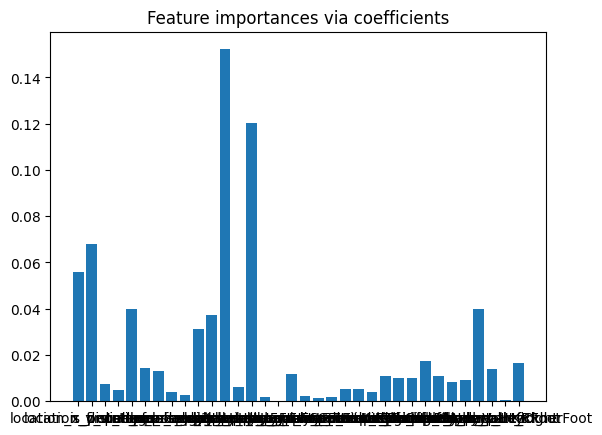

In [45]:
# Get coefficients of the features from Ridge regression

from sklearn.linear_model import RidgeCV
ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X_2, y_2)
importance = np.abs(ridge.coef_)
feature_names = np.array(X.columns)
plt.bar(height=importance, x=feature_names)
plt.title("Feature importances via coefficients")
plt.show()

In [46]:
# Features ranked by importance
importance_df = pd.DataFrame(importance, feature_names)
importance_df.sort_values(by=0, ascending=False)

,0
goalkeeper_x,0.152146
distance_to_goalie,0.120177
location_y_distance,0.067820
location_x_distance,0.055878
body_part_Head,0.039857
open_goal,0.039616
defenders_triangle,0.037422
defenders_3m_radius,0.031159
technique_Lob,0.017541
body_part_Right Foot,0.016340


In [47]:
#select top 15 features
from sklearn.feature_selection import SelectFromModel

threshold = np.sort(importance)[-15]

sfm = SelectFromModel(ridge, threshold=threshold).fit(X, y2)

print(f"Features selected by SelectFromModel: {feature_names[sfm.get_support()]}")

Features selected by SelectFromModel: ['is_penalty' 'open_goal' 'one_on_one' 'under_pressure'
 'defenders_3m_radius' 'defenders_triangle' 'play_pattern_From Free Kick'
 'play_pattern_From Kick Off' 'play_pattern_Other' 'technique_Backheel'
 'technique_Diving Header' 'technique_Half Volley' 'technique_Lob'
 'technique_Normal' 'technique_Overhead Kick' 'technique_Volley'
 'body_part_Head' 'body_part_Left Foot' 'body_part_Other'
 'body_part_Right Foot']


In [48]:
sfm.get_support()

array([False, False,  True, False,  True,  True,  True, False, False,
        True,  True, False, False, False, False, False,  True, False,
       False,  True, False,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [49]:
# SFM with LassoCV
from sklearn.linear_model import LassoCV 
lasso_cv = LassoCV(cv=5) 
lasso_cv.fit(X_2, y_2) 

LassoCV(cv=5)

In [50]:
sfm_lcv = SelectFromModel(lasso_cv, prefit=True)

# replace sfm_lcv with sfm to test features selected by SFM w/ ridge regression
df_lcv = pd.DataFrame(sfm_lcv.get_support(), X.columns, columns=["Selected"])

selected = []
for column in df_lcv[df_lcv["Selected"] == True].index:
    selected.append(column)

In [65]:
selected

['location_x_distance',
 'location_y_distance',
 'is_penalty',
 'first_time',
 'open_goal',
 'one_on_one',
 'under_pressure',
 'pass_angle',
 'pass_length',
 'defenders_3m_radius',
 'defenders_triangle',
 'goalkeeper_x',
 'goalkeeper_y',
 'distance_to_goalie',
 'play_pattern_From Corner',
 'play_pattern_From Counter',
 'play_pattern_From Free Kick',
 'play_pattern_From Goal Kick',
 'play_pattern_From Kick Off',
 'play_pattern_From Throw In',
 'play_pattern_Other',
 'technique_Backheel',
 'technique_Diving Header',
 'technique_Lob',
 'technique_Normal',
 'technique_Overhead Kick',
 'technique_Volley',
 'body_part_Head',
 'body_part_Other',
 'body_part_Right Foot']

In [42]:
def calculate_stats(results_test, results_pred, name):
    cm = confusion_matrix(results_test, results_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not a goal", "Goal"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix ({name})')
    plt.show()

    print(f"\n{name}")
    accuracy = accuracy_score(results_test, results_pred)
    precision = precision_score(results_test, results_pred)
    recall = recall_score(results_test, results_pred)
    f1 = f1_score(results_test, results_pred)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1:", f1)
    
    return f1

In [40]:
def logistic_regression():
    logistic_r = LogisticRegression()
    logistic_r.fit(X_train, y_train)
    y_pred = logistic_r.predict(X_test)

    f1 = calculate_stats(y_test, y_pred, "Logistic Regression")

    return logistic_r.predict_proba(X_test), f1

In [59]:
def decision_tree():
    dt = DecisionTreeClassifier(criterion="gini", max_depth=12, max_leaf_nodes=50, min_samples_split=100)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)

    f1 = calculate_stats(y_test, y_pred, "Decision Tree")

    viz_model = dtreeviz.model(dt,
                           X_train=X_train, y_train=y_train,
                           feature_names=X.columns, target_name="is_goal", class_names=["Not a goal", "Goal"])

    return dt.predict_proba(X_test), viz_model, f1

In [61]:
def gradient_boosted_tree():
    gbt = GradientBoostingClassifier(learning_rate=0.10, max_depth=12, min_samples_split=100, n_estimators=250, max_features=None)
    gbt.fit(X_train, y_train)
    y_pred = gbt.predict(X_test)
    
    calculate_stats(y_test, y_pred, "Gradient Boosted Tree")

    return gbt.predict_proba(X_test)

In [56]:
def preprocess_classifier_2(X, y):

    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

    X_train, y_train = SMOTE(sampling_strategy=0.3).fit_resample(X_train, y_train)

    return X_train, X_test, y_train, y_test

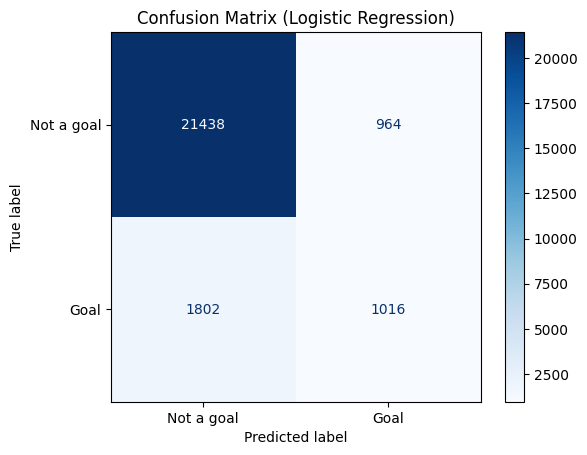


Logistic Regression
Accuracy: 0.890325138778747
Precision: 0.5131313131313131
Recall: 0.36053938963804116
F1: 0.42350979574822845


In [58]:
#testing the selected features using logistic_regression

X_selected = X[selected]

X_train, X_test, y_train, y_test = preprocess_classifier_2(X_selected, y2)

lor_xg = logistic_regression()

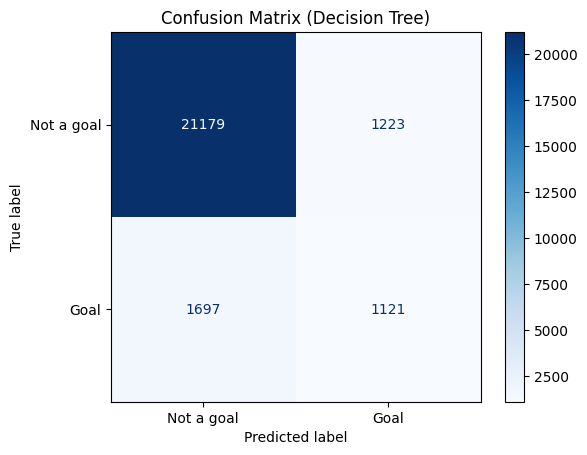


Decision Tree
Accuracy: 0.8842188739095955
Precision: 0.4782423208191126
Recall: 0.3977998580553584
F1: 0.4343277799302596


In [60]:
# testing the selected features using decision_tree

X_train, X_test, y_train, y_test = preprocess_classifier_2(X_selected, y2)

dt_xg = decision_tree()

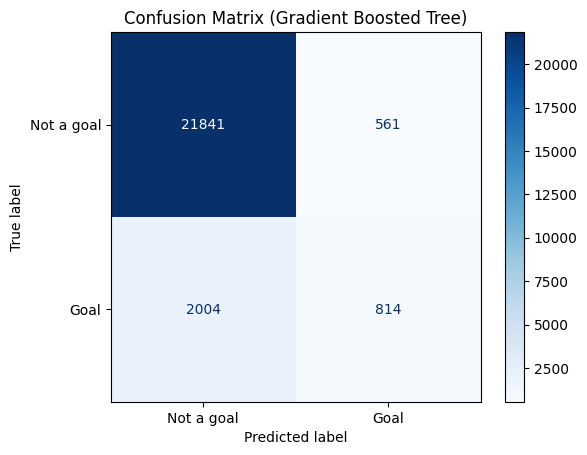


Gradient Boosted Tree
Accuracy: 0.8982950039651071
Precision: 0.592
Recall: 0.28885734563520227
F1: 0.3882661578821846


In [62]:
# testing the selected features using gradient_boosted_tree

gbt_xg = gradient_boosted_tree()